In [1]:
import numpy as np
import scipy.stats, scipy.special, scipy.optimize
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
n_samples = 500
sample_size = 400

#n_samples = 3
#sample_size = 100

variate_dim = 2
"""
Truth behid the sample distribution
"""
mu_real_vec = np.array([2., 1.])
cov_real_mat = np.array([[0.8, 0.2],[0.2, 0.8]])
print(cov_real_mat)
inv_cov_real_mat = np.linalg.inv(cov_real_mat)

sample_shape = (n_samples, sample_size, variate_dim)

samples = np.zeros(shape=sample_shape)

[[0.8 0.2]
 [0.2 0.8]]


In [3]:
"""negative log likelyhood function for a given sample"""
def neg_log_lhood(mu_vec=mu_real_vec, inv_cov_mat=inv_cov_real_mat, input_sample=[]):
    n_ln_lhood = 0.
    
    for input_sample_x in input_sample:
        #print(input_sample_x)
        n_ln_lhood += (input_sample_x - mu_vec).transpose().dot( inv_cov_mat.dot(input_sample_x - mu_vec) )
    
    n_ln_lhood *= 0.5
    
    return n_ln_lhood
    #return np.exp(-n_ln_lhood)

In [4]:
"""generate random samples"""
for i, sample in enumerate(samples):
    for j, sample_x in enumerate(sample):
        samples[i][j] = np.random.multivariate_normal(mu_real_vec, cov_real_mat)
    #print( neg_log_lhood(input_sample=samples[i]) )
    
    

In [5]:
"""Calculate maximium likely parameters analytically!"""
"""Numerical problem because matrix in general is not positive semi definite (which covariance should be)"""
mu_mls = []
cov_mls = []
for i, sample in enumerate(samples):
    """maximum likely mean"""
    mu_ml = sample.sum(axis=0)/float(sample_size)
    mu_mls.append(mu_ml)
    #print(mu_ml)
    #print("\n")
    cov_ml = np.zeros(shape=(variate_dim, variate_dim))
    for point in sample:
        #print(point)
        cov_ml += np.outer(point - mu_ml, point - mu_ml)
    
    cov_ml /= float(sample_size)
    cov_mls.append(cov_ml)
    #print(cov_ml)

mu_mls = np.array(mu_mls)
cov_mls = np.array(cov_mls)
print(mu_mls.shape)
print(cov_mls.shape)

(500, 2)
(500, 2, 2)


In [6]:
mu_mls_df = pd.DataFrame(mu_mls)
mu_mls_df.columns = ["E1", "E2"]
mu_mls_df.describe()

,E1,E2
count,500.000000,500.000000
mean,1.999133,0.999498
std,0.043301,0.045815
min,1.874689,0.850059
25%,1.971678,0.969689
50%,1.999361,0.999127
75%,2.029663,1.031394
max,2.126035,1.107652


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f88dfee6940>,
      dtype=object)

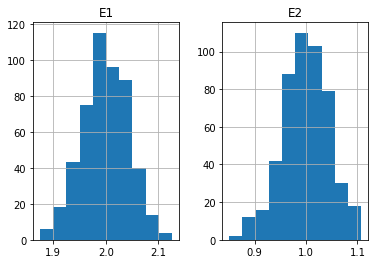

In [7]:
"""ML Estimators are very accurate around the real mean. Maximum deviation around 0.1/0.2 -> no bigger deviations recorded!"""
mu_mls_df.hist(["E1", "E2"])

In [8]:
flat_cov_mls = cov_mls.reshape((n_samples,variate_dim**2))
cov_mls_df = pd.DataFrame(flat_cov_mls)
cov_mls_df.columns = ["Var1", "Cov12", "Cov21", "Var2"]
cov_mls_df.describe()

,Var1,Cov12,Cov21,Var2
count,500.000000,500.000000,500.000000,500.000000
mean,0.796810,0.198734,0.198734,0.794790
std,0.057065,0.040014,0.040014,0.059683
min,0.629734,0.076752,0.076752,0.650814
25%,0.757636,0.172535,0.172535,0.749431
50%,0.796249,0.198191,0.198191,0.795455
75%,0.833174,0.225915,0.225915,0.835478
max,0.994036,0.329367,0.329367,1.004572


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f88dfdaa198>,
      dtype=object)

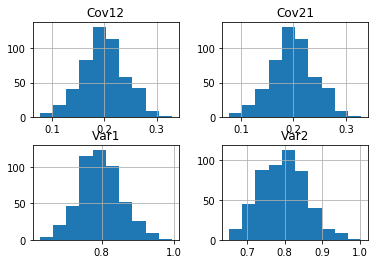

In [9]:
"""ML Estimators are very accurate around the real cov. Maximum deviation around 0.1/0.2 -> no bigger deviations recorded!"""
cov_mls_df.hist(["Var1", "Cov12", "Cov21", "Var2"])

In [10]:
"""Attempt to calculate ML parameters numerically"""
"""Failes because of violation positive semi definiteness"""
"""Not able to implement postive semi definite constraint on cov"""

"""generate symmetric matrix from list"""
"""not necesarily positive definite!"""
def sym_mat_from_list(el_list, dim=variate_dim):
    
    sym_mat = np.zeros(shape=(variate_dim, variate_dim))
    sym_mat[np.triu_indices(variate_dim)] = el_list
    sym_mat = sym_mat + sym_mat.transpose()
    sym_mat[np.diag_indices_from(sym_mat)] *= 0.5
    return sym_mat

mat_el = np.array(np.random.uniform( low=-5, high=5, size = (int(0.5*variate_dim*(variate_dim+1))) ))
print(mat_el)
sym_mat_from_list(mat_el)

[-0.42295328 -2.08870311  0.10532246]


array([[-0.42295328, -2.08870311],
       [-2.08870311,  0.10532246]])

In [11]:
cov_mat = np.random.uniform( low=-5, high=5, size = (variate_dim, variate_dim) )
cov_mat = cov_mat.transpose().dot(cov_mat)
print(cov_mat)

[[ 3.96140308  7.99607371]
 [ 7.99607371 16.70712367]]


In [12]:
ml_mus = []
ml_inv_covs = []
ml_covs = []
ml_inv_cov_els = []
for i, sample in enumerate(samples):
    
    """random initial values for optimization"""
    mu_vec_0 = np.random.uniform(low=-5, high=5, size = (variate_dim))
    inv_cov_mat_0_el = np.random.uniform( low=-5, high=5, size = (int(0.5*variate_dim*(variate_dim+1))) )
    inv_cov_mat_0 = sym_mat_from_list(inv_cov_mat_0_el)
    """make positive definite"""
    inv_cov_mat_0 = inv_cov_mat_0.transpose().dot(inv_cov_mat_0)
    inv_cov_mat_0_el = inv_cov_mat_0[np.triu_indices_from(inv_cov_mat_0)].flatten()
    pars_0 = np.concatenate( (mu_vec_0.flatten(), inv_cov_mat_0_el) )
    
    def arr_neg_log_lhood(pars):
        mu = pars[0:variate_dim]
        cov_el = pars[variate_dim:]
        """symmetrize cov matrix"""
        inv_cov = sym_mat_from_list(cov_el, dim=variate_dim)
        return neg_log_lhood(mu, inv_cov, samples[i] )
    
    """minimize negative log likelyhood"""    
    ml_pars = scipy.optimize.minimize(lambda pars: arr_neg_log_lhood(pars), x0=pars_0)
    ml_mus.append(ml_pars.x[:variate_dim])
    print(ml_pars.x[:variate_dim])
    """convert inverse covariance element list to covariance matrix"""
    inv_cov_el = ml_pars.x[variate_dim:]
    ml_inv_cov_els.append(inv_cov_el)
    ml_inv_cov = sym_mat_from_list(inv_cov_el)
    ml_inv_covs.append(ml_inv_cov)
    ml_covs.append(np.linalg.inv(ml_inv_cov))
    print(np.linalg.inv(ml_inv_cov))
    
    
    
    

[-3.09093362e+08  1.39233676e+09]
[[1.94713668e-10 6.80635271e-10]
 [6.80635271e-10 6.37071976e-10]]
[ 5.58283012e+08 -3.29257402e+08]
[[1.23097599e-10 1.62634242e-10]
 [1.62634242e-10 5.04123934e-11]]
[3.47784943e+08 3.91272298e+08]
[[-2.06453847e-09  4.14227316e-10]
 [ 4.14227316e-10 -2.14755610e-09]]
[4.69738364e+08 4.65494744e+07]
[[-5.37652149e-10  3.93495000e-10]
 [ 3.93495000e-10  6.96082601e-10]]
[-8.01279323e+08  8.35651962e+08]
[[5.77098051e-10 5.93965254e-10]
 [5.93965254e-10 5.93892577e-10]]
[-3.17347095e+08 -1.10820159e+08]
[[ 1.63426136e-10 -3.31241514e-10]
 [-3.31241514e-10  1.12049382e-10]]
[-9.86160693e+07  6.67766998e+08]
[[ 1.19944125e-10  4.61711009e-10]
 [ 4.61711009e-10 -1.53496273e-10]]
[ 8.46544977e+08 -4.80485423e+08]
[[-7.13268900e-12  1.18136024e-09]
 [ 1.18136024e-09  4.85947258e-10]]
[ 1.93475903e+08 -2.50451487e+08]
[[-4.59256288e-11  1.55268697e-11]
 [ 1.55268697e-11 -4.51124767e-11]]
[ 1.04002843e+08 -2.87955051e+08]
[[-5.25157250e-10 -2.83821813e-10]
 [

[-1.04441663e+09  7.89956302e+08]
[[-5.47898102e-10  5.81940824e-10]
 [ 5.81940824e-10  6.75196471e-11]]
[ 2.04384808e+08 -8.21583754e+07]
[[6.44731114e-09 6.34664752e-09]
 [6.34664752e-09 5.34794546e-09]]
[-3.06152194e+08 -6.52276872e+08]
[[-8.32885618e-11 -3.68112461e-10]
 [-3.68112461e-10 -9.16484629e-11]]
[1.73432102e+08 8.80335583e+07]
[[-1.05345807e-09  1.45506778e-10]
 [ 1.45506778e-10 -1.46396832e-09]]
[-2.65584198e+08 -3.04249363e+08]
[[ 1.51656256e-09 -1.01452809e-08]
 [-1.01452809e-08  3.90970127e-09]]
[-1.68799081e+08  3.60532063e+06]
[[-1.96874922e-10 -4.30070067e-11]
 [-4.30070067e-11 -9.26042497e-11]]
[-1.21757471e+07 -1.38461584e+08]
[[-3.81381392e-09 -2.27547970e-09]
 [-2.27547970e-09 -3.56320280e-09]]
[-2.52647593e+08 -5.37555259e+08]
[[ 2.99697227e-10 -4.31983686e-10]
 [-4.31983686e-10  4.03818101e-10]]
[-3.68764268e+08 -3.66029711e+08]
[[-6.93778264e-10  5.87842892e-10]
 [ 5.87842892e-10 -7.65665225e-10]]
[-5.26313394e+08  1.34323473e+08]
[[-1.08804557e-10 -2.082833

[20422.15713625  5512.35264379]
[[5.77422742e-07 6.95071514e-06]
 [6.95071514e-06 3.74404988e-06]]
[ 8.74153974e+07 -6.75885486e+08]
[[-3.22047956e-10  2.24775507e-10]
 [ 2.24775507e-10 -2.20852518e-10]]
[-2.33398115e+08 -3.34506988e+07]
[[5.59420047e-11 9.30886406e-10]
 [9.30886406e-10 2.36382005e-09]]
[-6.36425830e+08 -6.30663553e+08]
[[ 9.79092608e-10 -2.25578355e-09]
 [-2.25578355e-09  1.02369683e-09]]
[-1.46250797e+09  6.66758384e+08]
[[5.88263794e-11 7.82994526e-11]
 [7.82994526e-11 1.11459795e-11]]
[1.11892559e+09 3.51249601e+08]
[[ 1.17728383e-09 -2.56571863e-09]
 [-2.56571863e-09  3.65463421e-09]]
[-8.30613185e+08  6.93480444e+08]
[[3.17312197e-10 3.70472960e-10]
 [3.70472960e-10 2.01044375e-10]]
[7.51367169e+08 8.52481497e+08]
[[ 1.00152841e-09 -2.98687367e-10]
 [-2.98687367e-10  1.16018066e-11]]
[-1.62708829e+09  1.47812603e+08]
[[-2.85815053e-09 -1.11079042e-09]
 [-1.11079042e-09  1.38866526e-09]]
[2.18867273e+08 1.85255501e+08]
[[ 2.46620471e-09 -7.94061580e-09]
 [-7.94061

[ 2.58199330e+08 -3.03002234e+08]
[[-9.84466408e-11 -1.61893800e-10]
 [-1.61893800e-10 -5.23634867e-10]]
[-6.94552118e+07 -1.72309075e+08]
[[-2.76313944e-10 -5.48969694e-11]
 [-5.48969694e-11 -2.87228359e-11]]
[ 4.79353204e+08 -8.28487278e+08]
[[7.41019141e-10 2.09704075e-10]
 [2.09704075e-10 2.75337331e-11]]
[-2.48852413e+08 -3.53542032e+08]
[[ 9.24561387e-11 -1.86072468e-10]
 [-1.86072468e-10  7.85849115e-11]]
[1.12107122e+09 3.73890034e+08]
[[ 7.99424034e-11 -4.22807975e-11]
 [-4.22807975e-11 -1.06376965e-11]]
[ 5.47721964e+08 -3.51437948e+08]
[[1.32307650e-09 2.40060177e-09]
 [2.40060177e-09 1.22622685e-10]]
[-2.07024073e+09 -7.67585804e+08]
[[ 7.73972056e-11 -3.04940919e-10]
 [-3.04940919e-10  1.94501920e-10]]
[-475.99725913  190.59680946]
[[ 2.55927056e-05 -8.69026533e-05]
 [-8.69026533e-05  6.49958408e-05]]
[-1.66841782e+08 -1.07610969e+08]
[[-1.98136372e-10  5.23711464e-11]
 [ 5.23711464e-11 -7.73630956e-11]]
[-3.52050877e+08 -3.51295348e+08]
[[-8.51406632e-11  1.41310980e-10]


[-3.66489819e+08 -3.56509928e+08]
[[ 2.27889556e-10 -5.91985629e-10]
 [-5.91985629e-10  4.09887729e-10]]
[ 6.55160105e+08 -2.95595937e+08]
[[ 1.98418172e-09  4.38098574e-10]
 [ 4.38098574e-10 -7.05926439e-10]]
[3.14827798e+08 4.49778149e+08]
[[ 1.82239240e-10 -1.65391635e-10]
 [-1.65391635e-10  1.09146317e-10]]
[-1.80037690e+08  1.80835058e+08]
[[3.78752124e-10 4.78014389e-10]
 [4.78014389e-10 3.82307658e-10]]
[ 2.23374079e+09 -1.00126598e+09]
[[-4.21341468e-11  2.29458339e-10]
 [ 2.29458339e-10 -1.24899454e-10]]
[ 3.14125764e+08 -6.38170131e+06]
[[-2.33661500e-10  3.85392213e-10]
 [ 3.85392213e-10 -9.55634133e-10]]
[7.19499188e+07 7.99936933e+08]
[[ 1.95283901e-09 -1.09610300e-09]
 [-1.09610300e-09 -7.02337357e-10]]
[-42.63864004  53.25818881]
[[-0.00040211 -0.00016663]
 [-0.00016663  0.00116825]]
[ 1.10669258e+08 -1.42634388e+08]
[[3.59630710e-10 4.25109099e-10]
 [4.25109099e-10 3.91135422e-10]]
[3.71385403e+08 2.00734731e+08]
[[ 1.17568541e-10 -6.43786883e-10]
 [-6.43786883e-10  8.2

[424.70096743 941.46254021]
[[-1.80444414e-04 -1.92827469e-05]
 [-1.92827469e-05  8.73119902e-04]]
[ 3.48184975e+08 -7.80977787e+08]
[[1.32333409e-09 1.38542757e-09]
 [1.38542757e-09 4.87383430e-10]]
[-1.19811071e+08 -2.09977064e+08]
[[ 1.38335899e-10 -1.04366276e-09]
 [-1.04366276e-09 -3.59277275e-12]]
[-2.30917412e+09 -1.62390521e+09]
[[ 6.85892834e-10 -3.30879759e-10]
 [-3.30879759e-10  5.75789215e-11]]
[-1.48860960e+08 -3.64820659e+08]
[[ 1.50969318e-09 -1.71192457e-09]
 [-1.71192457e-09  3.98014761e-10]]
[-4.62297077e+08  4.90364607e+08]
[[-5.20753361e-12  2.73577934e-10]
 [ 2.73577934e-10  1.11811875e-10]]
[3.71358429e+08 5.97441343e+08]
[[ 1.77341266e-11 -3.14980980e-11]
 [-3.14980980e-11  1.62434302e-11]]
[-2.93095441e+08  5.33170718e+08]
[[-6.16652248e-12  2.74275202e-10]
 [ 2.74275202e-10  3.09633979e-11]]
[ 9.93044244e+07 -1.44893136e+08]
[[-2.03041444e-10  1.51652321e-10]
 [ 1.51652321e-10  4.76089324e-10]]
[-6.87601177e+08  1.92088093e+08]
[[-7.03103964e-11  4.01500666e-11

[ 4.04744870e+07 -1.51770592e+08]
[[-3.69559101e-10  1.14367657e-10]
 [ 1.14367657e-10 -3.76057902e-10]]
[ 8.35254682e+08 -2.18182598e+08]
[[-4.98693999e-11  5.68779781e-11]
 [ 5.68779781e-11 -7.20484112e-11]]
[1.11648067e+09 6.28937864e+08]
[[ 1.06136508e-10 -3.99038805e-10]
 [-3.99038805e-10  2.41547261e-10]]
[ 4.52234270e+08 -1.31278842e+08]
[[3.15976249e-10 2.73435755e-09]
 [2.73435755e-09 8.33744671e-09]]
[4.00742296e+08 8.07523429e+08]
[[ 2.97757930e-10 -1.18416978e-10]
 [-1.18416978e-10 -2.62110860e-10]]
[ -903.6568404  -2845.50463387]
[[ 3.21144688e-05  4.50117021e-05]
 [ 4.50117021e-05 -1.19306131e-05]]
[-5.86127963e+08 -6.64383309e+08]
[[ 3.05019449e-10 -1.17545344e-09]
 [-1.17545344e-09  1.30085349e-09]]
[-2.34762099e+08  1.86248228e+08]
[[1.05097897e-09 2.77640255e-09]
 [2.77640255e-09 1.52108394e-09]]
[5.07118607e+07 3.95487201e+08]
[[-1.04607446e-09  1.23230881e-10]
 [ 1.23230881e-10 -8.62605393e-11]]
[-1.01687306e+09  1.53002431e+08]
[[-1.23140711e-09  6.22853238e-10]
 [